# Tooploox Data Science Intern - Cifar10 project

## PART III - Final learning

In [ ]:
%matplotlib inline
# Since we are using different enviroments using Python 2 and 3 interchangeably we need this inports
from __future__ import print_function
from __future__ import division, print_function

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import math
import os

import sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

# Importing custom functions for the project
from downloadANDload import *
from plot_functions import *
random_state = 42

import sys
print("Check Python version")
sys.version

# Load CNN data

Features from the Cifar10 images were extracted in the terminal using the Incepcion v3 Convolutional Neural Network pretrained model. I took the output from penultimate layer maxpool(0:3). This was done by running cifar-10_experiment.py script, which uses classify_image.py program from official tensorflow tutorials. 

It took about 3-4 hours to do it, which is quite good actually. This is due to the super powerfull Geforce GTX 1080 on my friend's computer, otherwise it could be more like 15 hours :)

In [25]:
data_path = "/home/kyp/tooploox/MyProject/incepcion/"
X_train_full, y_train_full, X_test, y_test = load_CNN(data_path)

Loading: test_batch.npz
Loading: data_batch_1.npz
Loading: data_batch_2.npz
Loading: data_batch_3.npz
Loading: data_batch_4.npz
Loading: data_batch_5.npz


As always it is good to know the shape of the data we are working with. Here we have the vecor of 2048 CNN codes for 60 000 Cifar10 images.

In [26]:
print("Shape of loaded data:\n X_train_full: {},\n X_test: {},\n y_train_full: {},\n y_test: {} "
      .format(X_train_full.shape,X_test.shape, y_train_full.shape,y_test.shape))

Shape of loaded data:
 X_train_full: (50000, 2048),
 X_test: (10000, 2048),
 y_train_full: (50000,),
 y_test: (10000,) 


Having a list of classes might be also useful later.

In [6]:
class_names = load_class_names()

As before we chop off some training data for validation.

In [27]:
# Create hold-out validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, 
                                                  test_size=0.2, random_state=random_state)

In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(X_train)))
print("- Validation-set:\t\t{}".format(len(X_valid)))
print("- Test-set:\t\t{}".format(len(X_test)))

Size of:
- Training-set:		40000
- Validation-set:		10000
- Test-set:		10000


# Training and hyperparameter optimisation

Normalisation is important for many algorithms.

In [8]:
sc = StandardScaler().fit(X_train)
X_train = sc.transform(X_train)
X_valid = sc.transform(X_valid)

###  GridSearchCV

In [7]:
N = 1000 # For making training set smaller
X_tr = X_train#[:N]
y_tr = y_train#[:N]

In [8]:
%%time
clf = SVC(random_state=random_state)

parameter_space = [{'kernel': ['linear'], 'C': [0.001, 0.01,0.1, 1, 10, 100]},
                    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [0.1, 1, 10, 100]}]
k = 3
clf = GridSearchCV(clf, parameter_space , cv=k,n_jobs = -1, scoring='accuracy')
clf.fit(X_tr, y_tr)
print("# Tuning hyper-parameters for accuracy")
print()
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))
print("Best cross-validated score: {:.3f}".format(clf.best_score_))
print()
print("Classification accuracy on validation set: {:.3f}".format(clf.score(X_valid,y_valid)))
print("Training size: {}".format( len(X_tr)))
print()

# Tuning hyper-parameters for accuracy
()
Best parameters set found on development set:
()
{'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
()
Grid scores on development set:
()
0.900 (+/-0.004) for {'kernel': 'linear', 'C': 0.001}
0.887 (+/-0.001) for {'kernel': 'linear', 'C': 0.01}
0.882 (+/-0.003) for {'kernel': 'linear', 'C': 0.1}
0.882 (+/-0.003) for {'kernel': 'linear', 'C': 1}
0.882 (+/-0.003) for {'kernel': 'linear', 'C': 10}
0.882 (+/-0.003) for {'kernel': 'linear', 'C': 100}
0.793 (+/-0.003) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.001}
0.872 (+/-0.007) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.0001}
0.887 (+/-0.009) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.897 (+/-0.005) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.892 (+/-0.007) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.905 (+/-0.003) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.892 (+/-0.007) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
0.902 (+/-0.002) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.000

/home/kyp/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


In [9]:
%%time
clf = LinearSVC(random_state=random_state)

parameter_space = {'C': np.logspace(-5,1,7)}
k = 3

clf = GridSearchCV(clf, parameter_space , cv=k, scoring='accuracy')
clf.fit(X_tr, y_tr)
print("# Tuning hyper-parameters for accuracy")
print()
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))
print("Best cross-validated score: {:.3f}".format(clf.best_score_))
print()
print("Classification accuracy on validation set: {:.3f}".format(clf.score(X_valid,y_valid)))
print("Training size: {}".format( len(X_tr)))
print()

# Tuning hyper-parameters for accuracy
()
Best parameters set found on development set:
()
{'C': 0.001}
()
Grid scores on development set:
()
0.875 (+/-0.002) for {'C': 1.0000000000000001e-05}
0.893 (+/-0.003) for {'C': 0.0001}
0.901 (+/-0.002) for {'C': 0.001}
0.884 (+/-0.004) for {'C': 0.01}
0.864 (+/-0.004) for {'C': 0.10000000000000001}
0.856 (+/-0.001) for {'C': 1.0}
0.855 (+/-0.001) for {'C': 10.0}
Best cross-validated score: 0.901
()
Classification accuracy on validation set: 0.902
Training size: 40000
()
CPU times: user 28min 18s, sys: 4.91 s, total: 28min 23s
Wall time: 28min 2s


### SGD for faster learning

In [77]:
%%time

clfSGD = SGDClassifier(random_state=random_state)

parameter_space = [{'loss': ['hinge',  'squared_hinge'],"n_iter": [1, 5, 10],
                   'alpha': [0.0001, 0.001, 0.01, 0.1],
              'penalty': ["l1", "l2"] }]
k = 3
clfSGD = GridSearchCV(clfSGD, parameter_space , cv=k, scoring='accuracy')
clfSGD.fit(X_tr, y_tr)
print("# Tuning hyper-parameters for accuracy")
print()
print("Best parameters set found on development set:")
print()
print(clfSGD.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clfSGD.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))
print("Best cross-validated score: {:.3f}".format(clfSGD.best_score_))
print("Classification accuracy on validation set: {:.3f}".format(clfSGD.score(X_valid,y_valid)))
print()
print("Training size: {}".format( len(X_tr)))
print()
print()

# Tuning hyper-parameters for accuracy
()
Best parameters set found on development set:
()
{'penalty': 'l2', 'alpha': 0.01, 'n_iter': 10, 'loss': 'squared_hinge'}
()
Grid scores on development set:
()
0.791 (+/-0.049) for {'penalty': 'l1', 'alpha': 0.0001, 'n_iter': 1, 'loss': 'hinge'}
0.790 (+/-0.043) for {'penalty': 'l2', 'alpha': 0.0001, 'n_iter': 1, 'loss': 'hinge'}
0.828 (+/-0.032) for {'penalty': 'l1', 'alpha': 0.0001, 'n_iter': 5, 'loss': 'hinge'}
0.819 (+/-0.043) for {'penalty': 'l2', 'alpha': 0.0001, 'n_iter': 5, 'loss': 'hinge'}
0.827 (+/-0.039) for {'penalty': 'l1', 'alpha': 0.0001, 'n_iter': 10, 'loss': 'hinge'}
0.823 (+/-0.072) for {'penalty': 'l2', 'alpha': 0.0001, 'n_iter': 10, 'loss': 'hinge'}
0.791 (+/-0.021) for {'penalty': 'l1', 'alpha': 0.0001, 'n_iter': 1, 'loss': 'squared_hinge'}
0.782 (+/-0.036) for {'penalty': 'l2', 'alpha': 0.0001, 'n_iter': 1, 'loss': 'squared_hinge'}
0.816 (+/-0.023) for {'penalty': 'l1', 'alpha': 0.0001, 'n_iter': 5, 'loss': 'squared_hinge'}

### Bayesian Optimisation
Here I will try more fancy method for hyperparameter optimisation.

In [67]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from skopt import gp_minimize

cv = KFold(n_splits=3, random_state=random_state) # We want to use 3-fold CV to compute the loss in each iteration

In [71]:
svc_clf1 = SVC(kernel='rbf') 

def objective_svc1(params): 
    C, gamma = params
    svc_clf1.set_params(C=C, 
                      gamma=gamma) 
    
    return -np.mean(cross_val_score(svc_clf1, X_tr, y_tr, cv=cv, n_jobs=-1,
                                    scoring="accuracy")) 

# Search space for the two parameters
space  = [ (10**-3, 10**3, "uniform"), # C
          (10**-4, 10**1, "uniform")] # gamma

# Initial values (optional)
x0 = [1, 10**-2]

In [72]:
%%time
res_gp = gp_minimize(func=objective_svc1, dimensions=space, x0=x0, 
                     n_calls=25, random_state=random_state, n_random_starts=5, kappa=1.9)
print("Best score with Bayesian optimisation: {:.3f}".format(-res_gp.fun))
print("Best parameters with Bayesian optimisation:\nC: {}\ngamma: {}"
      .format(res_gp.x[0],res_gp.x[1]))
print("Training size: {}".format( len(X_tr)))
print()


Best score with Bayesian optimisation: 0.826
Best parameters with Bayesian optimisation:
C: 263.814805629
gamma: 0.0001
Training size: 1000
()
CPU times: user 30.8 s, sys: 2.97 s, total: 33.8 s
Wall time: 1min 3s


In [70]:
%%time
svc_opt1 = SVC(kernel='rbf',
             C=res_gp.x[0],
             gamma=res_gp.x[1]).fit(X_tr,y_tr)
print("Classification accuracy on validation set: {:.3f}".format(accuracy_score(y_valid, svc_opt1.predict(X_valid))))
print("Classification accuracy on test set: {:.3f}".format(accuracy_score(y_test, svc_opt1.predict(X_test))))

print()

Classification accuracy on validation set: 0.845
Classification accuracy on test set: 0.843
()
CPU times: user 29 s, sys: 24 ms, total: 29.1 s
Wall time: 29 s


Sorry I shouldn't look on test set here yet... 

# Train final model and report results

The choice of the model is clearly SVC with Radial Basis Kernel, C=10 and gamma=0.0001 as it achieved the best performance on the validation set. Now I am going to train it on the full set and see generalisation performance on the test set. 

In [13]:
sc = StandardScaler().fit(X_train_full)
X_train_full = sc.transform(X_train_full)
X_test_sc = sc.transform(X_test)

In [19]:
%%time
# Train on the full training set using best classifier with best parameters
clf = SVC(kernel='rbf',C=10,gamma= 0.0001, random_state=random_state)
clf.fit(X_train_full, y_train_full)

# By using the predict() method and accuracy_score metric
clf_prediction = clf.predict(X_test)
clf_accuracy = accuracy_score(y_test, clf_prediction)
print("Final classification accuracy on the test set using score method: {:.3f}".format(clf.score(X_test, y_test)))
print("Final classification accuracy on test set, using the accuracy_score() function: {:.3f}".format(clf_accuracy))
print()
print("Training size: {}".format( len(X_train_full)))
print()

Final classification accuracy on the test set using score method: 0.910
Final classification accuracy on test set, using the accuracy_score() function: 0.910

Training size: 50000

CPU times: user 20min 39s, sys: 236 ms, total: 20min 39s
Wall time: 20min 39s


In [51]:
print("Final classification accuracy on the test set using score method: {:.3f}".format(clf.score(X_test_sc, y_test_sc)))
print("Final classification accuracy on test set, using the accuracy_score() function: {:.3f}".format(clf_accuracy))
print()
print("Training size: {}".format( len(X_train_full)))
print()

Final classification accuracy on the test set using score method: 0.771
Final classification accuracy on test set, using the accuracy_score() function: 0.910

Training size: 50000



### SAVE RESULTS

In [10]:
from sklearn.externals import joblib
filename = "/home/kyp/tooploox/MyProject/BestCifar10Classifier.joblib.pkl"

In [47]:
# Saving classifier
_ = joblib.dump(clf, filename, compress=9)

In [11]:
# Loading classifier
best_clf = joblib.load(filename)
best_clf

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
print("Final classification accuracy on the test set using score method: {:.3f}".format(best_clf.score(X_test_sc, y_test)))

Final classification accuracy on the test set using score method: 0.910


In [14]:
best_clf_prediction = best_clf.predict(X_test_sc)

We cam see that LinearSVC achieves good results as well, while it takes much less time to train and evaluate.

In [16]:
#SECOND BEST CLASSIFIER WITH FASTER LEARNING 
%%time
# Train on the full training set using best classifier with best parameters
clf =  LinearSVC(C=0.0001, random_state=random_state)
clf.fit(X_train_full, y_train_full)

# Build-in score method
test_score = clf.score(X_test, y_test)

# By using the predict() method and accuracy_score metric
clf_prediction = clf.predict(X_test)
clf_accuracy = accuracy_score(y_test, clf_prediction)
print("Final classification accuracy on the test set using score method: {:.3f}".format(test_score))
print("Final classification accuracy on test set, using the accuracy_score() function: {:.3f}".format(clf_accuracy))
print()
print("Training size: {}".format( len(X_train_full)))
print()

Final classification accuracy on the test set using score method: 0.887
Final classification accuracy on test set, using the accuracy_score() function: 0.887

Training size: 50000

CPU times: user 32 s, sys: 228 ms, total: 32.2 s
Wall time: 32 s


#### Confusion Matrix
We can have a look at the confusion matrix now to see which classes are easiest to predict and which are hardest. Also we can see which classes are most similar to each other (according to the computer). I recommend opening confusion matrix in the separate window for readability.

In [15]:
cm = confusion_matrix(y_test, best_clf_prediction)
print('Confusion matrix\n{}'.format(cm))

Confusion matrix
[[918   6  11   3   4   0   1   2  41  14]
 [ 10 949   2   3   0   1   2   1   4  28]
 [ 18   1 888  27  28  12  18   5   2   1]
 [  5   1  22 843  14  77  25   8   3   2]
 [  4   0  27  24 887   5  21  29   2   1]
 [  2   0  11  81  15 869   8  13   1   0]
 [  5   0  15  20  16   5 935   1   3   0]
 [  7   0   9  20  21  19   3 918   1   2]
 [ 27   7   1   2   0   0   0   1 955   7]
 [ 10  33   2   4   0   0   1   1  12 937]]


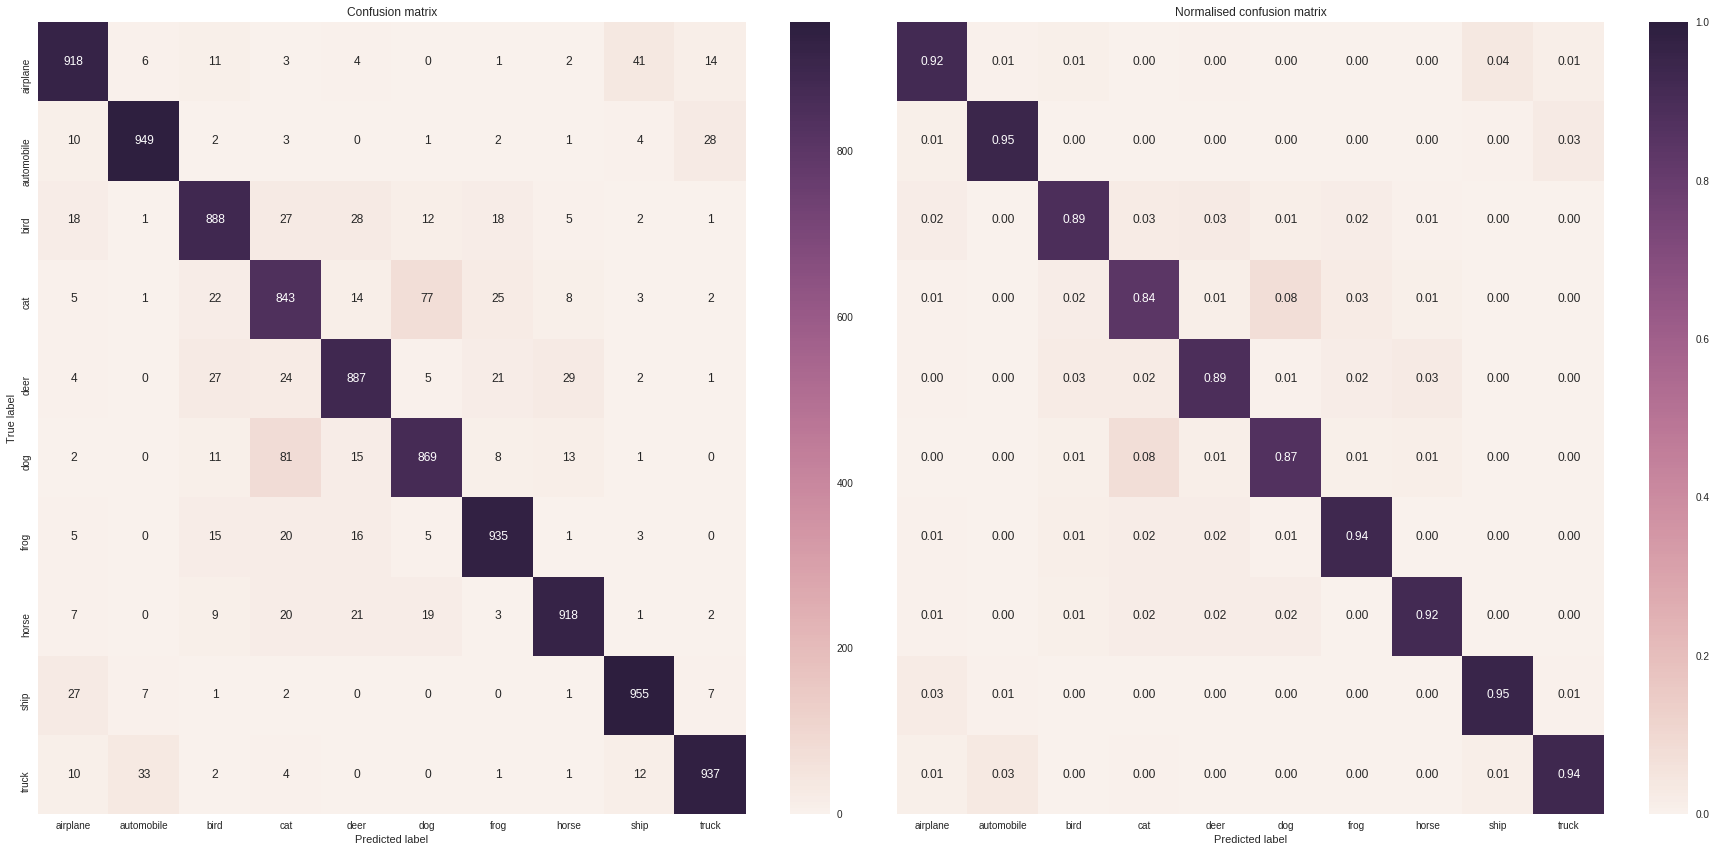

In [16]:
fig = plt.figure(figsize=(25,12))
ax1 = fig.add_subplot(121)
plot_confusion_matrix(cm, normalize=False, classes=class_names) # un-normalized
ax2 = fig.add_subplot(122)
plot_confusion_matrix(cm, normalize=True, classes=class_names, title='Normalised confusion matrix') # normalized
ax2.get_yaxis().set_visible(False)
fig.tight_layout()

Overall results seems to be really good, accuracy is above 90% for many classes. Cats are hardest class to predict (previously it was dogs when using HoG features), while cars and ships are still the easiest. We can have a look on the examples of the missclassifications now...

Loading: test_batch


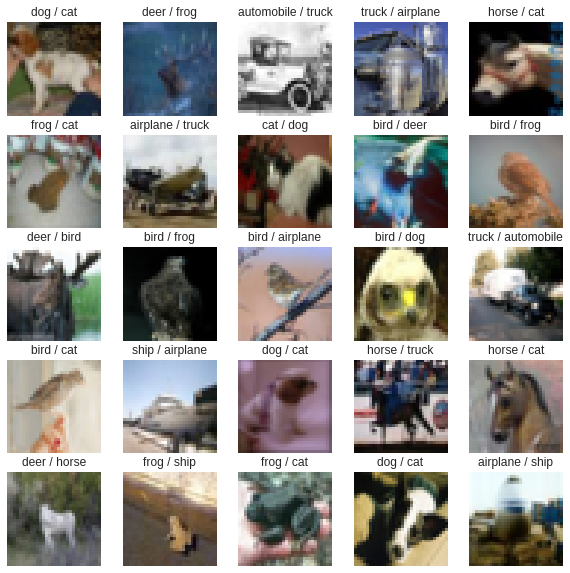

In [21]:
# Examples of missclassifications
dataset_path = "/home/kyp/tooploox/MyProject/cifar-10-batches-py/"
images, labels = load_test_set(dataset_path)

wrong = np.where(y_test != best_clf_prediction)[0] 

fig = plt.figure(figsize=(10,10))
for i in range(25):
    fig.add_subplot(5,5,(i+1),xticks=[], yticks=[])
    idx = wrong[i]
    plt.title("{} / {}".format(class_names[y_test[idx]], class_names[best_clf_prediction[idx]]))
    plt.imshow(images[idx])

# Extras

## xgBoost

In [57]:
from xgboost import XGBClassifier
X_tr = X_train
y_tr = y_train

In [49]:
clf = XGBClassifier(objective = 'multi:softprob' )
parameters = {
    'max_depth': (3, 12),
    'learning_rate': (0.01, 0.5), 
    'n_estimators': (20, 200), 
    'gamma': (0, 0.5), 
    'min_child_weight': (1, 5),
    'subsample': (0.1, 1),
    'colsample_bytree': (0.1, 1)}

clf = GridSearchCV(clf, parameters, n_jobs=1, cv=2)
    
clf.fit(X_tr, y_tr)
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print(score)
print()
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))


/home/kyp/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)


0.45

colsample_bytree: 0.1
gamma: 0.5
learning_rate: 0.01
max_depth: 3
min_child_weight: 1
n_estimators: 200
subsample: 1


In [60]:
%%time
# Optimizing hyperparameters in LinearSVC
clf = XGBClassifier(objective = 'multi:softprob' )

parameters = {
    'max_depth': (3,6,9,12),
    'learning_rate': (0.01, 0.5), 
    'n_estimators': (20,50,100, 200), 
    'gamma': (0, 0.5), 
    'min_child_weight': (1, 5),
    'subsample': (0.1, 1),
    'colsample_bytree': (0.1, 1)}

k = 3
clf =  RandomizedSearchCV(clf, parameters, cv=k,n_jobs=-1, scoring='accuracy')
clf.fit(X_tr, y_tr)
##########################################################################
#############REPORT#######################################################
##########################################################################
print("# Tuning hyper-parameters for accuracy")
print()
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))
print("Best cross-validated score: {:.3f}".format(clf.best_score_))
print()
print("Classification accuracy on validation set: {:.3f}".format(clf.score(X_valid,y_valid)))
print("Training size: {}".format( len(X_tr)))
print()

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'subsample': 1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.1}

Grid scores on development set:

0.831 (+/-0.002) for {'subsample': 1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1}
0.844 (+/-0.002) for {'subsample': 0.1, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.1}
0.821 (+/-0.002) for {'subsample': 1, 'n_estimators': 50, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.1}
0.844 (+/-0.003) for {'subsample': 1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 1}
0.826 (+/-0.003) for {'subsample': 0.1, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'learnin

/home/kyp/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Classification accuracy on validation set: 0.868
Training size: 40000

CPU times: user 1h 24min 9s, sys: 18.6 s, total: 1h 24min 28s
Wall time: 7h 4min 24s


In [63]:
# xgBoost with optimised parameters
clf = XGBClassifier(objective = 'multi:softprob', subsample= 1, n_estimators = 200,
                    nthread=7, min_child_weight = 5, max_depth = 9, 
                    learning_rate = 0.01, gamma= 0, colsample_bytree= 0.1 )
clf.fit(X_train_full, y_train_full)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=9,
       min_child_weight=5, missing=None, n_estimators=200, nthread=7,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [66]:
print("Final classification accuracy on the test set using score method: {:.3f}".format(clf.score(X_test, y_test)))
print()
print("Training size: {}".format( len(X_train_full)))
print()

Final classification accuracy on the test set using score method: 0.866

Training size: 50000



This is less than SVM with RBF kernel, however the benefit of this method is quick evaluation time (tree based).

## Random Forest 

In [128]:
from sklearn.ensemble import RandomForestClassifier
# Train on the full training set using best classifier with best parameters
clf = RandomForestClassifier(max_depth=10, n_estimators=50,random_state=random_state)
clf.fit(X_train_full, y_train_full)

# Build-in score method
test_score = clf.score(X_test, y_test)

# By using the predict() method and accuracy_score metric
clf_prediction = clf.predict(X_test)
clf_accuracy = accuracy_score(y_test, clf_prediction)

print("Final classification accuracy on the test set using score method: {:.3f}".format(test_score))
print("Final classification accuracy on test set, using the accuracy_score() function: {:.3f}"
      .format(clf_accuracy, clf.score(X_test, y_test)))

Final classification accuracy on the test set using score method: 0.831
Final classification accuracy on test set, using the accuracy_score() function: 0.831
